Load required packages: 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy import stats

from sklearn.metrics import pairwise_distances, r2_score
from sklearn.model_selection import cross_val_predict

from functions_rw import calc_D0, calc_D1, calc_D2
from functions_rw import concat_df
from functions_rw import get_gmm_fitted, get_fcfp_gmm_rw
from functions_rw import get_binning_grid, get_fcfp_binning_grid_rw
from functions_rw import get_nonzero_features
from functions_rw import get_KFold, get_trained_RF
from functions_rw import mantel_test
from functions_rw import transform

from os import listdir     

Initialize metavariables: 

In [2]:
''' Metavariables '''
np.random.seed(np.int(2703))
PATH_DATA = '../Data/Cycles/'
FILENAMES = sorted(listdir(PATH_DATA))
MIN_SAMPLES_LEAF = 5 
N_ITER = 10

N_REP = 3
N_TREES = 200#[10,100,200,400,600,800,1000][2]
TYPE = 'full'#['full','tied','diag','spherical'][0]
N_CELLS_REP_c = 2000 #Cycle II
N_CELLS_REP_i = 2000 #Cycle II
N_MIX = 128
N_BINS = 128
FEATURES = ['FL1-H','FSC-H','SSC-H']#,'FL2-H','FL3-H','SSC-H','FL4-H'][0:job] #

Load in simulated microbial community compositions: 

In [3]:
target = pd.read_csv('../Data/Metadata_Cycles.csv',index_col='FCM_ID')
target = target.loc[target.loc[:,'Reactor cycle'] == 1]
target_MV = pd.read_csv('../Data/Metadata_FCM_Cycles.csv', index_col='Sample name')
target_MV = target_MV.loc[target_MV.loc[:,'Cycle'] == 1]

Load OTU-table: 

In [4]:
otu_table = pd.read_table('../Data/OTU_table_Cycles.csv', index_col='Group', header=0, float_precision='high')
otu_table = otu_table.loc[target.loc[:,'sample_title'].apply(str).values,:] 
otu_table.drop(['label','numOtus'], axis=1, inplace=True)
otu_table = otu_table.iloc[:,:-1]
otu_table.index = target.index
otus = list(otu_table.columns)

Determine $\alpha$-diversity values: 

In [5]:
d0 = calc_D0(otu_table)   
d1 = calc_D1(otu_table)
d2 = calc_D2(otu_table)

Determine $\beta$-diversity values: 

In [6]:
bc_otu_table = pd.DataFrame(pairwise_distances(otu_table, metric='braycurtis'), index=otu_table.index, columns=otu_table.index)

Create empty dataframes to store fingerprints, both for the FCM data for which we have 16S data, and for the ones it is missing (denoted with "MV":missing values). 

In [7]:
fcfp_final_gmm = pd.DataFrame()
fcfp_MV_final_gmm = pd.DataFrame()
fcfp_final_grid = pd.DataFrame()
fcfp_MV_final_grid = pd.DataFrame()

Concatenate all flow cytometry files in `PATH_DATA`: 

In [8]:
df = concat_df(target, N_CELLS_REP_c, PATH_DATA, FILENAMES)

Transform the data by $f(x) = \text{asinh}(x)$: 

In [9]:
df_trans = transform(df,FEATURES)

Fit a Gaussian Mixture Model to the data: 

In [10]:
gmm = get_gmm_fitted(df_trans, FEATURES, N_MIX, TYPE, transform_bool=False)

Retrieve fingerprints per sample using the fitted GMM and store them in one dataframe: 

In [11]:
fcfp_gmm = get_fcfp_gmm_rw(target, N_REP, N_CELLS_REP_i, N_MIX, FEATURES, gmm, True, PATH_DATA, FILENAMES)
fcfp_gmm_MV = get_fcfp_gmm_rw(target_MV, N_REP, N_CELLS_REP_i, N_MIX, FEATURES, gmm, True, PATH_DATA, FILENAMES)

Fit a grid to each bivariate combination of the channels: 

In [12]:
grids = get_binning_grid(df_trans,FEATURES,N_MIX,False,False)

Retrieve fingerprints per sample using this collection of grids, vectorize the cell counts, and store them in one dataframe: 

In [13]:
fcfp_grid = get_fcfp_binning_grid_rw(target, N_REP, N_CELLS_REP_i, FEATURES, grids, True, False, PATH_DATA, FILENAMES)
fcfp_grid_MV = get_fcfp_binning_grid_rw(target_MV, N_REP, N_CELLS_REP_i, FEATURES, grids, True, False, PATH_DATA, FILENAMES)

Perform rapid $\alpha$-diversity estimations, by applying the Hill-diversity formulas directly to the fingerprint data: 

In [14]:
D0_fcfp_gmm = calc_D0(fcfp_gmm)
D1_fcfp_gmm = calc_D1(fcfp_gmm)
D2_fcfp_gmm = calc_D2(fcfp_gmm)
    
D0_fcfp_grid = calc_D0(fcfp_grid)
D1_fcfp_grid = calc_D1(fcfp_grid)
D2_fcfp_grid = calc_D2(fcfp_grid)

Calculate Kendall's $\tau_B$ between cytometric and true $\alpha$-diversity: 

In [15]:
k_uns_test_d0_gmm, p_k_uns_test_d0_gmm = stats.kendalltau(D0_fcfp_gmm,d0)
k_uns_test_d1_gmm, p_k_uns_test_d1_gmm = stats.kendalltau(D1_fcfp_gmm,d1)
k_uns_test_d2_gmm, p_k_uns_test_d2_gmm = stats.kendalltau(D2_fcfp_gmm,d2)

k_uns_test_d0_grid, p_k_uns_test_d0_grid = stats.kendalltau(D0_fcfp_grid,d0)
k_uns_test_d1_grid, p_k_uns_test_d1_grid = stats.kendalltau(D1_fcfp_grid,d1)
k_uns_test_d2_grid, p_k_uns_test_d2_grid = stats.kendalltau(D2_fcfp_grid,d2)

Values for $D_1$: 

In [16]:
print('Kendall tau_B for PhenoGMM:' + str(k_uns_test_d1_gmm))
print('P-value:' + str(p_k_uns_test_d1_gmm))

print('Kendall tau_B for PhenoGrid:' + str(k_uns_test_d1_grid))
print('P-value::' + str(p_k_uns_test_d1_grid))

Kendall tau_B for PhenoGMM:0.453968253968
P-value:9.7965749245e-05
Kendall tau_B for PhenoGrid:0.552380952381
P-value::2.13643175426e-06


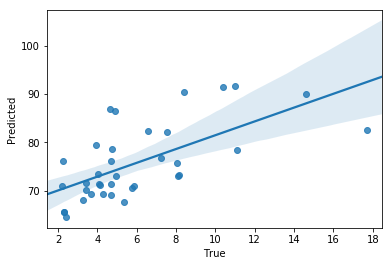

In [17]:
d1_gmm = pd.DataFrame({'True':d1.iloc[:,0],'Predicted': D1_fcfp_gmm.iloc[:,0]}, index=d1.index)
sns.regplot(x='True', y='Predicted', data=d1_gmm)

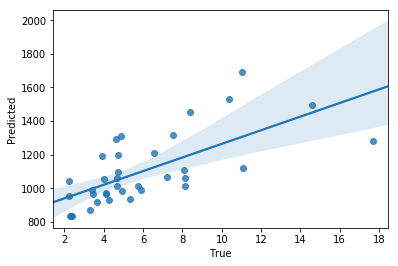

In [18]:
d1_grid = pd.DataFrame({'True':d1.iloc[:,0],'Predicted': D1_fcfp_grid.iloc[:,0]}, index=d1.index)
sns.regplot(x='True', y='Predicted', data=d1_grid)

Calculate the $\beta$-diversity between samples using the Bray-Curtis dissimilarity and correlate it with the true compositions using the mantel test: 

In [19]:
bc_fcfp_gmm = pd.DataFrame(pairwise_distances(fcfp_gmm, metric='braycurtis'), index=fcfp_gmm.index, columns=fcfp_gmm.index)
bc_fcfp_grid = pd.DataFrame(pairwise_distances(fcfp_grid, metric='braycurtis'), index=fcfp_grid.index, columns=fcfp_grid.index)

mantel_beta_div_gmm, p_mantel_beta_div_gmm = mantel_test(bc_otu_table, bc_fcfp_gmm)
mantel_beta_div_grid, p_mantel_beta_div_grid = mantel_test(bc_otu_table, bc_fcfp_grid)

print('Mantel correlation between PhenoGMM and True Beta-diversities:' + str(mantel_beta_div_gmm))
print('Mantel correlation between PhenoGrid and True Beta-diversities:' + str(mantel_beta_div_grid))

Mantel correlation between PhenoGMM and True Beta-diversities:0.485354178726
Mantel correlation between PhenoGrid and True Beta-diversities:0.574328086735


Predict $D_1$ using Random Forest regression based on the cytometric fingerprints: 

In [20]:
kcv = get_KFold(10, shuffle = False)
fcfp_features_gmm = get_nonzero_features(fcfp_gmm)  
rf_gmm = get_trained_RF(fcfp_gmm, d1.loc[fcfp_gmm.index].values.ravel(), fcfp_features_gmm, 200, 5, 50, kcv)
preds_oob_gmm = rf_gmm.best_estimator_.oob_prediction_
preds_cv_gmm = cross_val_predict(rf_gmm.best_estimator_, fcfp_gmm.loc[:,fcfp_features_gmm],d1.loc[fcfp_gmm.index].values.ravel(), cv=kcv)

r2_cv_d1_gmm = r2_score(d1,preds_cv_gmm)
k_cv_d1_gmm, p_k_cv_d1_gmm = stats.kendalltau(d1,preds_cv_gmm)
D1_gmm_mv = rf_gmm.predict(fcfp_gmm_MV.loc[:,fcfp_features_gmm])
D1_gmm_mv = pd.DataFrame(D1_gmm_mv, index=target_MV.index, columns=['D1_pred'])

print('R²(CV) for supervised estimations using PhenoGMM: ' + str(r2_cv_d1_gmm))
print('Kendall tau_B(CV) for supervised estimations using PhenoGMM: ' + str(k_cv_d1_gmm))
print('P-value: ' + str(p_k_cv_d1_gmm))

r2_oob_d1_gmm = r2_score(d1,preds_oob_gmm)
k_oob_d1_gmm, p_k_oob_d1_gmm = stats.kendalltau(d1,preds_oob_gmm)
print('R²(OOB) for supervised estimations using PhenoGMM: ' + str(r2_oob_d1_gmm))
print('Kendall tau_B(OOB) for supervised estimations using PhenoGMM: ' + str(k_oob_d1_gmm))
print('P-value: ' + str(p_k_oob_d1_gmm))

R²(CV) for supervised estimations using PhenoGMM: 0.287911816392
Kendall tau_B(CV) for supervised estimations using PhenoGMM: 0.511111111111
P-value: 1.15492369703e-05
R²(OOB) for supervised estimations using PhenoGMM: 0.317556914853
Kendall tau_B(OOB) for supervised estimations using PhenoGMM: 0.533333333333
P-value: 4.72547726543e-06


In [21]:
kcv = get_KFold(10, shuffle=False)
fcfp_features_grid = get_nonzero_features(fcfp_grid)  
rf_grid = get_trained_RF(fcfp_grid, d1.values.ravel(), fcfp_features_grid, 200, 5, 50, kcv)
preds_oob_grid = rf_grid.best_estimator_.oob_prediction_
preds_cv_grid = cross_val_predict(rf_grid.best_estimator_, fcfp_grid.loc[:,fcfp_features_grid],d1.loc[fcfp_gmm.index].values.ravel(), cv=kcv)

r2_cv_d1_grid = r2_score(d1,preds_cv_grid)
k_cv_d1_grid, p_k_cv_d1_grid = stats.kendalltau(d1,preds_cv_grid)
D1_grid_mv = rf_grid.predict(fcfp_grid_MV.loc[:,fcfp_features_grid])
D1_grid_mv = pd.DataFrame(D1_grid_mv, index=target_MV.index, columns=['D1_pred'])

print('R²(CV) for supervised estimations using PhenoGrid: ' + str(r2_cv_d1_grid))
print('Kendall tau_B(CV) for supervised estimations using PhenoGrid: ' + str(k_cv_d1_grid))
print('P-value: ' + str(p_k_cv_d1_grid))

r2_oob_d1_grid = r2_score(d1,preds_oob_grid)
k_oob_d1_grid, p_k_oob_d1_grid = stats.kendalltau(d1,preds_oob_grid)
print('R²(OOB) for supervised estimations using PhenoGrid: ' + str(r2_oob_d1_grid))
print('Kendall tau_B(OOB) for supervised estimations using PhenoGrid: ' + str(k_oob_d1_grid))
print('P-value: ' + str(p_k_oob_d1_grid))

R²(CV) for supervised estimations using PhenoGrid: 0.145202562218
Kendall tau_B(CV) for supervised estimations using PhenoGrid: 0.349206349206
P-value: 0.00273011626331
R²(OOB) for supervised estimations using PhenoGrid: 0.216659559345
Kendall tau_B(OOB) for supervised estimations using PhenoGrid: 0.444444444444
P-value: 0.000136818331627


Text(0, 0.5, '$D_1$')

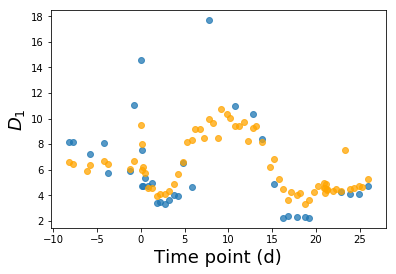

In [22]:
booleanDictionary = {True: 'FCM', False: '16S'}
target_MV.loc[:,'Sample'] = pd.isnull(target_MV.loc[:,'D1.tax'])
target_MV.loc[:,'Sample'] = target_MV.loc[:,'Sample'].replace(booleanDictionary)
target_MV.rename(columns={'Cycle':'Survey'}, inplace=True)
target_MV = target_MV.loc[target_MV.loc[:,'Survey'] == 1]
D1_gmm_mv.loc[:,'Time point (d)'] = target_MV.loc[D1_gmm_mv.index,'Time point (d)']
D1_gmm_mv.loc[:,'Survey'] = 1

fig, ax = plt.subplots()
sns.regplot(x='Time point (d)',y='D1.tax', data=target_MV.loc[target_MV.loc[:,'Sample'] == '16S'], ax=ax, fit_reg=False, scatter_kws={'alpha':0.75})
sns.regplot(x='Time point (d)', y='D1_pred', data=D1_gmm_mv, ax=ax, color='orange', fit_reg=False, scatter_kws={'alpha':0.75})
ax.set_xlabel('Time point (d)',fontsize=18)
ax.set_ylabel(r'$D_1$',fontsize=18)